In [1]:
import numpy as np 
import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading data
data = pd.read_csv(r"C:\Users\garys\Desktop\TFG\TREBALL\BASE DE DADES\diabetes_binary_health_indicators_BRFSS2015.csv")
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
# preprocessing
x = data.drop("Diabetes_binary", axis=1)
# x["Age"] /= x["Age"].max()
y = data["Diabetes_binary"]

print(f"Shape: {x.shape}, {y.shape}")
x.head()

Shape: (253680, 21), (253680,)


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
# building set of train_val and test 
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2)

print(f"Train_val Counts: {x_train_val.shape[0]}\nTest Counts: {x_test.shape[0]}")

Train_val Counts: 202944
Test Counts: 50736


In [5]:
# building model
class Keras_Model(keras.Model):
    def __init__(self):
        super(Keras_Model, self).__init__()

        self.act = keras.layers.Activation("relu")
        self.dropout = keras.layers.Dropout(0.25)

        self.block_1 = keras.Sequential()
        for i in range(1):
            self.block_1.add(keras.layers.Dense(128))
            self.block_1.add(self.act)
#             self.block_1.add(self.dropout)

        self.block_2 = keras.Sequential()
        for i in range(1):
            self.block_2.add(keras.layers.Dense(64))
            self.block_2.add(self.act)
#             self.block_2.add(self.dropout)

        self.block_3 = keras.Sequential()
        for i in range(1):
            self.block_3.add(keras.layers.Dense(32))
            self.block_3.add(self.act)
            self.block_3.add(self.dropout)

        self.fc_out = keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training=None, mask=None):
        x = self.block_1(inputs)

        x = self.block_2(x)

        x = self.block_3(x)

        x = self.fc_out(x)
        return x

    def get_config(self):
        config = super(Keras_Model, self).get_config()
        config.update()
        return config

In [6]:
# callbacks
def lr_scheduler(base_lr, epochs):
    def scheduler(epoch, lr):
        p = epoch / epochs

        if p > 0.9:
            lr_n = base_lr * 1e-3

        elif p > 0.75:
            lr_n = base_lr * 1e-2

        elif p >= 0.5:
            lr_n = base_lr * 1e-1

        else:
            lr_n = lr

        print(f"[INFO] {epoch + 1}/{epochs} LR From ", lr, " to ", lr_n)

        return lr_n

    return LearningRateScheduler(scheduler)

In [7]:
learning_rate = 5e-3
epochs = 50

opt = keras.optimizers.SGD(
    learning_rate=learning_rate,
    momentum=0.9,
    decay=1e-4,
)
model = Keras_Model()
model.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["mae", "acc"]
)

In [8]:
history = model.fit(
        x=x_train_val, y=y_train_val,
        validation_data=(x_test, y_test),
        epochs=epochs,
        callbacks=[lr_scheduler(base_lr=learning_rate, epochs=epochs)],
        verbose=0,
    )

[INFO] 1/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 2/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 3/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 4/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 5/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 6/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 7/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 8/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 9/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 10/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 11/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 12/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 13/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 14/50 LR From  0.004999999888241291  to  0.004999999888241291
[INFO] 15/50 LR From  0.004999999888241291 

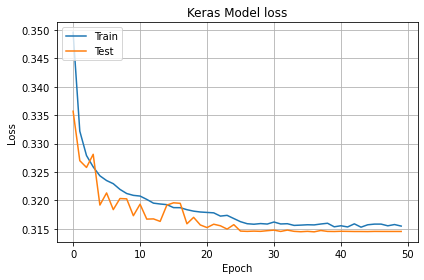

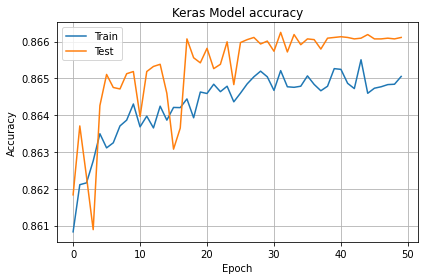

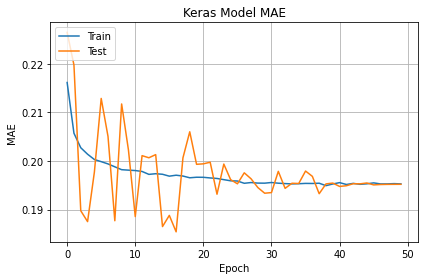

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Keras Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Keras Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


In [10]:
log = model.evaluate(x_test,y_test)

print(f"\nTest Loss: {log[0]}\nTest Accuracy: {log[2]}\nTest MAE: {log[1]}")

1586/1586 [==============================] - 3s 2ms/step - loss: 0.3145 - mae: 0.1952 - acc: 0.8661

Test Loss: 0.31453484296798706
Test Accuracy: 0.8661108613014221
Test MAE: 0.1951998472213745
